In [203]:
import numpy as np
from mat4py import loadmat
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import preprocessing

In [204]:
data = loadmat('Data/Dataset1.mat')
data2 = loadmat('Data/Dataset2.mat')
data.keys()

dict_keys(['X', 'y', 'yval', 'Xval'])

In [205]:
data.keys()
x = data['X']
y = data['y']
label = []
for i in range(len(y)):
    label.append(y[i][0])
    
datas = pd.DataFrame(x, columns=['x1','x2'])
datas['y'] = label

In [206]:

x2 = data2['X']
y2= data2['y']
label2 = []
for i in range(len(y2)):
    label2.append(y2[i][0])
    
datas2 = pd.DataFrame(x2, columns=['x1','x2'])
datas2['y'] = label2

In [207]:
class PreprocessData:
    def NomalizeData(Data):
        Data=np.array(Data)
        lenght = len(Data)
        normalizedData = []
        
        for i in range (lenght):
            normalizedData.append(float((Data[i] - min(Data) ) / ( max(Data) - min(Data)) ))
            
        return normalizedData
    
    def TestAndTrain(Data , PercentageOfTrainData):
        PercentageOfTrainData = float(PercentageOfTrainData / 100)
        Train_DataFrame = Data.sample(frac=PercentageOfTrainData)
        Test_DataFrame =Data.drop(Train_DataFrame.index)
        
        return Train_DataFrame , Test_DataFrame
    

    
def k_fold(data_length, k):
    folds = []
    fold_size = data_length/k
    for i in range(k):
        folds.append([int(i*fold_size),int(((i+1)*fold_size)) - 1])
    return folds

def get_folds(data, k):
    return np.split(data, k)

    

In [208]:
#split data1
Dataset = PreprocessData.TestAndTrain(datas , 80)


TrainData = Dataset[0]
TestData = Dataset[1]
data = np.array(TrainData)
Y = TrainData['y']
Y = np.array(Y)
data = TrainData.drop('y',axis=1)
X = np.array(data)
y_test = np.array(TestData['y'])
X_test = np.array(TestData.drop('y',axis=1))

#kfold dataset 1 



#split data2 
Dataset2 = PreprocessData.TestAndTrain(datas2 , 80)


TrainData2 = Dataset2[0]
TestData2 = Dataset2[1]
data2 = np.array(TrainData2)
Y2 = TrainData2['y']
Y2 = np.array(Y2)
data2 = TrainData2.drop('y',axis=1)
X2 = np.array(data2)
y_test2 = np.array(TestData2['y'])
X_test2 = np.array(TestData2.drop('y',axis=1))

In [209]:
# 10 fold of dataset 2
cp_data2 = datas2


cp_data2 = cp_data2.to_numpy()

np.random.shuffle(cp_data2)
cp_data2 = np.delete(cp_data2 , 0 , 0)
cp_data2 = np.delete(cp_data2 , 10 , 0)
cp_data2 = np.delete(cp_data2 , 20 , 0)
# print(len(cp_data2))
folds2 = get_folds(cp_data2,10)


In [210]:
# 10 fold dataset 1
# 10 fold of dataset 2
cp_data1 = datas


cp_data1 = cp_data1.to_numpy()

np.random.shuffle(cp_data2)
cp_data1 = np.delete(cp_data1 , 0 , 0)

# print(len(cp_data2))
folds1 = get_folds(cp_data1,10)

In [211]:
folds1 = np.array(folds1)
folds1.shape

(10, 21, 3)

In [212]:

Y[Y==0] = -1
Y2[Y2==0] = -1
y_test[y_test==0] = -1
y_test2[y_test2==0] = -1

In [213]:
def sigmoid(z):
    return (1 / (1 + np.exp(-1*z)))
def hypotesis(x,w,b):
    z = b+w[0][0]*x[:,0] + w[0][1]*x[:,1]
    yhat = sigmoid(z)
    return yhat

def hypotesis1(x,w,b):
    z = b+w[0]*x[:,0] + w[1]*x[:,1]
    yhat = sigmoid(z)
    return yhat
    
    

In [214]:
def predict(x,y,w,b):
    pred = hypotesis(x,w,b)


    predicted  = hypotesis(x,w,b)
    predicted[predicted > 0.5] =1
    predicted[predicted <= 0.5] = -1
    acc2 = np.mean(y == predicted)
    print('Youre accuracy is  = ',acc2*100)
    

In [215]:
class SVM:
    def __init__(self, kernel='rbf', C=10.0, max_iteration=500, degree=3, sigma=1):
        self.kernel = {'rbf'   : lambda x,y: np.exp(-sigma*np.sum((y - x[:,np.newaxis])**2, axis=-1))}[kernel]
        self.C = C
        self.max_iter = max_iteration

    def CalcLoss(self, t, multiV, u):
        t = (np.clip(multiV + t*u, 0, self.C) - multiV)[1]/u[1]
        return (np.clip(multiV + t*u, 0, self.C) - multiV)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y * 2 - 1
        self.lambdas = np.zeros_like(self.y, dtype=float)
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y

        for _ in range(self.max_iter):
            for indexes in range(len(self.lambdas)):
                RightColumn = np.random.randint(0, len(self.lambdas))
                checkRL = self.K[[[indexes, indexes], [RightColumn, RightColumn]], [[indexes, RightColumn], [indexes, RightColumn]]]
                multiV = self.lambdas[[indexes, RightColumn]]
                summeddata = 1 - np.sum(self.lambdas * self.K[[indexes, RightColumn]], axis=1)
                u = np.array([-self.y[RightColumn], self.y[indexes]])
                t_max = np.dot(summeddata, u) / (np.dot(np.dot(checkRL, u), u) + 1E-15)
                self.lambdas[[indexes, RightColumn]] = multiV + u * self.CalcLoss(t_max, multiV, u)

        lended, = np.nonzero(self.lambdas > 1E-15)
        self.b = np.mean((1.0 - np.sum(self.K[lended] * self.lambdas, axis=1)) * self.y[lended])
  
    def decide(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

    def predict(self, X):
        return (np.sign(self.decide(X)) + 1) // 2


In [216]:
def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  # print('step0')
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  # print('step1')
  svm_model.fit(X, y)
  z_model = svm_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  Z = z_model.reshape(xx.shape)
  # print('step2')
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  # plt.contour(xx, yy, Z, cmap=plt.cm.gray, levels=[0.5])
  plt.title(title)

In [217]:
Y2[Y2==-1] = 0
y_test2[y_test2==-1] = 0
sv = SVM(C=0.1,sigma=0.1)
sv.fit(X2,Y2)
r = sv.decide(X2)
pred = sv.predict(X2)
np.mean(Y2 == pred)


0.5478260869565217

In [218]:
pred

array([1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 1.

In [219]:
Cs = [0.01,0.03,0.1,0.3,1,3,10,30]
sigmas = [0.01,0.03,0.1,0.3,1,3,10,30]
Y2[Y2==-1] = 0
y_test2[y_test2==-1] = 0

In [19]:
result = []
count = 1
for c in  Cs:
    for si in sigmas:
        sv = SVM(C=c,sigma=si)
        sv.fit(X2,Y2)
        pred = sv.predict(X2)
        acc = np.mean(Y2 == pred)
        testpred = sv.predict(X_test2)
        acctest = np.mean(y_test2 == testpred)
        objective = (acctest*100*1.5)+acc*100 
        result.append([c,si,acc,acctest,objective])
        print(str(count)+'- C = '+str(round(c,2)) + ' ,Sigma = ' + str(round(si ,2)) + ', train accuracy = '+str(round(acc*100,2))+' ,test accuracy = '+str(round(acctest*100 ,2))+' ,objective =  ' +str(round(objective,2)))
        count +=1
        
        
        

1- C = 0.01 ,Sigma = 0.01, train accuracy = 54.35 ,test accuracy = 60.69 ,objective =  145.39
2- C = 0.01 ,Sigma = 0.03, train accuracy = 51.59 ,test accuracy = 56.65 ,objective =  136.57
3- C = 0.01 ,Sigma = 0.1, train accuracy = 55.36 ,test accuracy = 56.07 ,objective =  139.47
4- C = 0.01 ,Sigma = 0.3, train accuracy = 61.01 ,test accuracy = 61.27 ,objective =  152.92
5- C = 0.01 ,Sigma = 1, train accuracy = 70.0 ,test accuracy = 72.25 ,objective =  178.38
6- C = 0.01 ,Sigma = 3, train accuracy = 76.23 ,test accuracy = 79.19 ,objective =  195.02
7- C = 0.01 ,Sigma = 10, train accuracy = 78.7 ,test accuracy = 80.35 ,objective =  199.22
8- C = 0.01 ,Sigma = 30, train accuracy = 83.91 ,test accuracy = 83.24 ,objective =  208.77
9- C = 0.03 ,Sigma = 0.01, train accuracy = 54.35 ,test accuracy = 60.69 ,objective =  145.39
10- C = 0.03 ,Sigma = 0.03, train accuracy = 51.3 ,test accuracy = 56.07 ,objective =  135.41
11- C = 0.03 ,Sigma = 0.1, train accuracy = 59.42 ,test accuracy = 60.12 ,

In [161]:
Cs = [0.01,0.03,0.1,0.3,1,3,10,30]
sigmas = [0.01,0.03,0.1,0.3,1,3,10,30]
Y[Y==-1] = 0
y_test[y_test==-1] = 0

In [163]:
result1 = []
count = 1
for c in  Cs:
    for si in sigmas:
        sv = SVM(C=c,sigma=si)
        sv.fit(X,Y)
        pred = sv.predict(X)
        acc = np.mean(Y== pred)
        testpred = sv.predict(X_test)
        acctest = np.mean(y_test == testpred)
        objective = (acctest*100*1.5)+acc*100 
        result1.append([c,si,acc,acctest,objective])
        print(str(count)+'- C = '+str(round(c,2)) + ' ,Sigma = ' + str(round(si ,2)) + ', train accuracy = '+str(round(acc*100,2))+' ,test accuracy = '+str(round(acctest*100 ,2))+' ,objective =  ' +str(round(objective,2)))
        count +=1

1- C = 0.01 ,Sigma = 0.01, train accuracy = 52.07 ,test accuracy = 42.86 ,objective =  116.36
2- C = 0.01 ,Sigma = 0.03, train accuracy = 67.46 ,test accuracy = 59.52 ,objective =  156.74
3- C = 0.01 ,Sigma = 0.1, train accuracy = 79.88 ,test accuracy = 88.1 ,objective =  212.02
4- C = 0.01 ,Sigma = 0.3, train accuracy = 79.88 ,test accuracy = 88.1 ,objective =  212.02
5- C = 0.01 ,Sigma = 1, train accuracy = 80.47 ,test accuracy = 88.1 ,objective =  212.62
6- C = 0.01 ,Sigma = 3, train accuracy = 81.66 ,test accuracy = 88.1 ,objective =  213.8
7- C = 0.01 ,Sigma = 10, train accuracy = 86.39 ,test accuracy = 90.48 ,objective =  222.1
8- C = 0.01 ,Sigma = 30, train accuracy = 91.12 ,test accuracy = 90.48 ,objective =  226.84
9- C = 0.03 ,Sigma = 0.01, train accuracy = 67.46 ,test accuracy = 59.52 ,objective =  156.74
10- C = 0.03 ,Sigma = 0.03, train accuracy = 78.11 ,test accuracy = 83.33 ,objective =  203.11
11- C = 0.03 ,Sigma = 0.1, train accuracy = 79.88 ,test accuracy = 88.1 ,obje

In [14]:
sv = SVM(C=40,sigma=40)
sv.fit(X2,Y2)
pred = sv.predict(X2)
acc = np.mean(Y2 == pred)
testpred = sv.predict(X_test2)
acctest = np.mean(y_test2 == testpred)
print('test accuracy  = '+str(acctest*100) +'accuracy = '+str(acc*100))

test accuracy  = 99.42196531791907accuracy = 99.56521739130434


In [220]:
#split data1
Dataset = PreprocessData.TestAndTrain(datas , 90)


TrainData = Dataset[0]
TestData = Dataset[1]
data = np.array(TrainData)
Y = TrainData['y']
Y = np.array(Y)
data = TrainData.drop('y',axis=1)
X = np.array(data)
y_test = np.array(TestData['y'])
X_test = np.array(TestData.drop('y',axis=1))

#split data2 
Dataset2 = PreprocessData.TestAndTrain(datas2 , 90)


TrainData2 = Dataset2[0]
TestData2 = Dataset2[1]
data2 = np.array(TrainData2)
Y2 = TrainData2['y']
Y2 = np.array(Y2)
data2 = TrainData2.drop('y',axis=1)
X2 = np.array(data2)
y_test2 = np.array(TestData2['y'])
X_test2 = np.array(TestData2.drop('y',axis=1))

In [16]:
# Cs = [0.01,0.03,0.1,0.3,1,3,10,30]
# sigmas = [0.01,0.03,0.1,0.3,1,3,10,30]
# Y2[Y2==-1] = 0
# y_test2[y_test2==-1] = 0

In [20]:
# result10 = []
# count = 1
# for c in  Cs:
#     for si in sigmas:
#         sv = SVM(C=c,sigma=si)
#         sv.fit(X2,Y2)
#         pred = sv.predict(X2)
#         acc = np.mean(Y2 == pred)
#         testpred = sv.predict(X_test2)
#         acctest = np.mean(y_test2 == testpred)
#         objective = (acctest*100*1.5)+acc*100 
#         result10.append([c,si,acc,acctest,objective])
#         print(str(count)+' C = '+str(c) + ' ,Sigma = ' + str(si) + ', train accuracy = '+str(acc*100)+' ,test accuracy = '+str(acctest*100)+' ,objective =  ' +str(objective))
#         count +=1

In [24]:
sortedresult  = sorted(result, key=lambda x : x[4] ,reverse=True)

In [27]:
bestC = sortedresult[1][0]
bestSigma = sortedresult[1][1]

In [164]:

sortedresult1  = sorted(result1, key=lambda x : x[4] ,reverse=True)
bestC1 = sortedresult1[1][0]
bestSigma1 = sortedresult1[1][1]

In [176]:
worstC = sortedresult[63][0]
WorstSigma = sortedresult[63][1]
worstC1 = sortedresult1[50][0]
worstSigma1 = sortedresult1[50][1]

In [222]:
folds2 = np.array(folds2)
folds2.shape


(10, 86, 3)

********
fold1 ==> 🛠train accuracy = 99.35 ,🔬test accuracy = 98.84
************


/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_982/1026111450.py:14: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


********
fold2 ==> 🛠train accuracy = 99.22 ,🔬test accuracy = 100.0
************
********
fold3 ==> 🛠train accuracy = 99.35 ,🔬test accuracy = 98.84
************
********
fold4 ==> 🛠train accuracy = 99.35 ,🔬test accuracy = 97.67
************
********
fold5 ==> 🛠train accuracy = 99.35 ,🔬test accuracy = 98.84
************
********
fold6 ==> 🛠train accuracy = 99.22 ,🔬test accuracy = 97.67
************
********
fold7 ==> 🛠train accuracy = 99.35 ,🔬test accuracy = 100.0
************
********
fold8 ==> 🛠train accuracy = 99.22 ,🔬test accuracy = 98.84
************
********
fold9 ==> 🛠train accuracy = 99.48 ,🔬test accuracy = 98.84
************
********
fold10 ==> 🛠train accuracy = 99.35 ,🔬test accuracy = 100.0
************


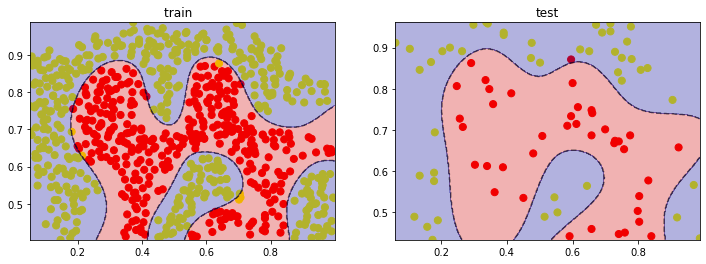

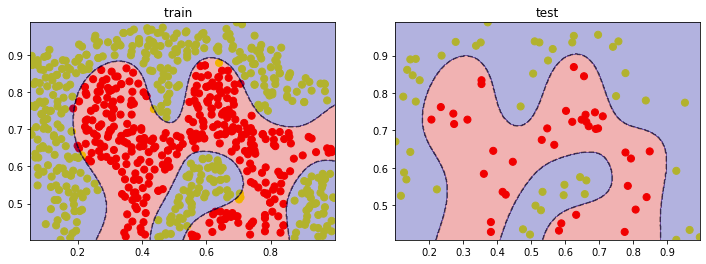

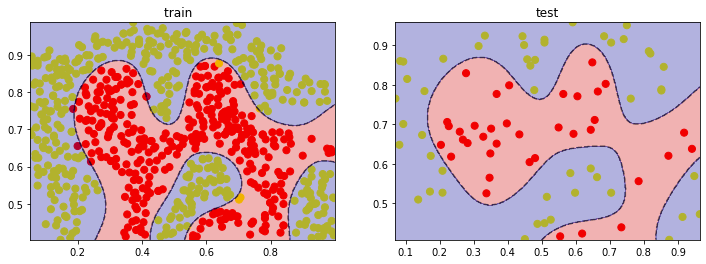

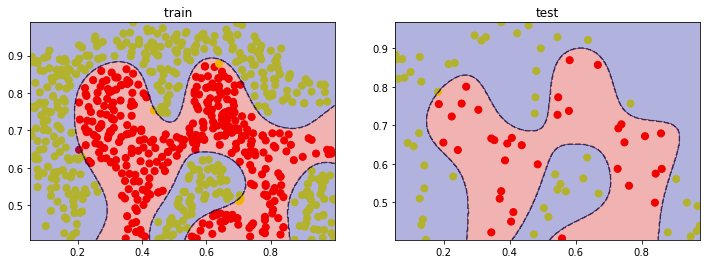

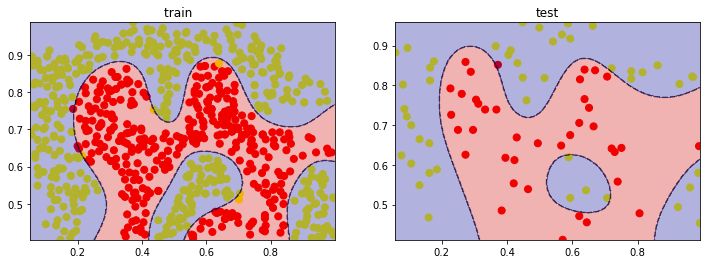

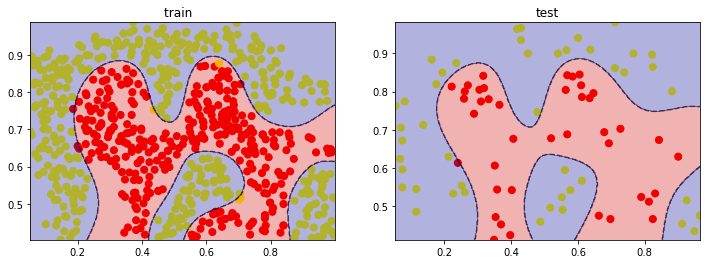

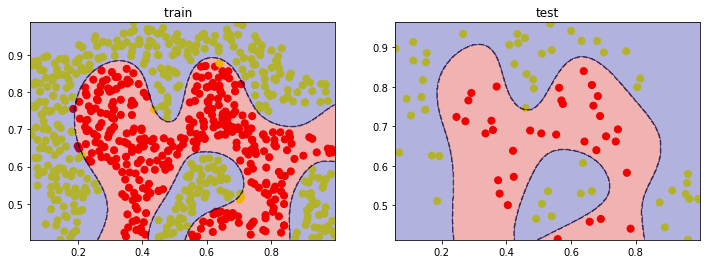

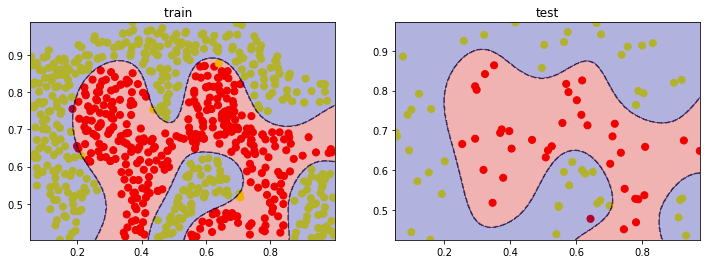

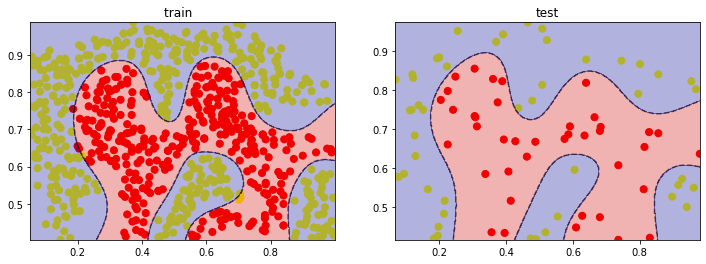

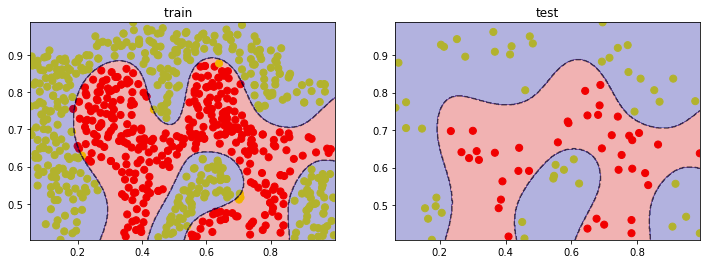

In [223]:
KfoldResult2 = []
for i in range(len(folds2)):
    testdata = folds2[i]
    traindata = folds2[0]
    
    for j in range(len(folds2)):
        if( i != j ):
            traindata = np.concatenate((traindata , folds2[j]))
    for d in range(traindata.shape[0]):
        if(d < 86):
            traindata = np.delete(traindata , d , 0)
        
    
            

    Xn =  np.delete(traindata , 2 , 1)
    Yn = traindata[:,2]
    Xntest = np.delete(testdata , 2 , 1)
    Yntest = testdata[:,2]
    Yn[Yn==-1] = 0
    Yntest[Yntest==-1] = 0
    
   
    
    sv = SVM(C=bestC,sigma=bestSigma)
    sv.fit(Xn,Yn)
    pred = sv.predict(Xn)
    acc = np.mean(Yn == pred)
    testpred = sv.predict(Xntest)
    acctest = np.mean(Yntest == testpred)
    objective = (acctest*100*1.5)+acc*100 
    KfoldResult2.append([acc,acctest])
    print('********')
    print('fold'+str(i+1)+' ==> 🛠train accuracy = '+str(round(acc*100,2))+' ,🔬test accuracy = '+str(round(acctest*100 ,2)) )
    print('************')
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
    test_plot(Xn , Yn , SVM( C=bestC, sigma=bestSigma) , axs[0] , 'train  ')
    test_plot(Xntest , Yntest , SVM( C=bestC, sigma=bestSigma) , axs[1] , 'test')



********
fold1 ==> 🛠train accuracy = 94.71 ,🔬test accuracy = 100.0
************


/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_982/1026111450.py:14: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


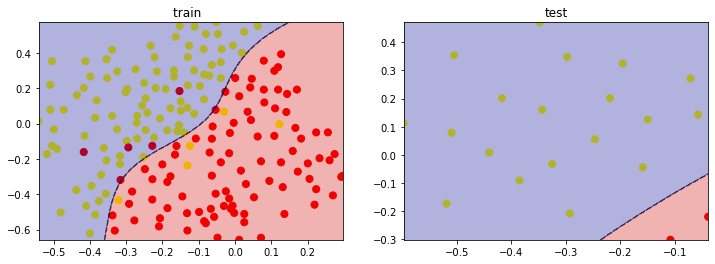

********
fold2 ==> 🛠train accuracy = 95.77 ,🔬test accuracy = 76.19
************


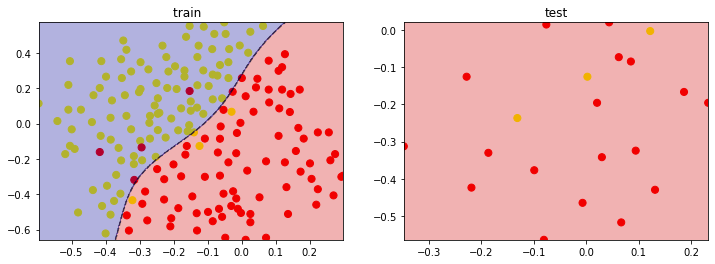

********
fold3 ==> 🛠train accuracy = 94.18 ,🔬test accuracy = 90.48
************


/Users/saeed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saeed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_982/3682414558.py:34: RuntimeWarning: invalid value encountered in floor_divide
  return (np.sign(self.decide(X)) + 1) // 2
/Users/saeed/opt/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/saeed/opt/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


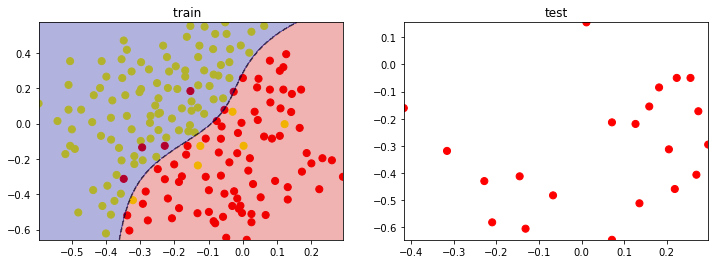

********
fold4 ==> 🛠train accuracy = 93.12 ,🔬test accuracy = 100.0
************


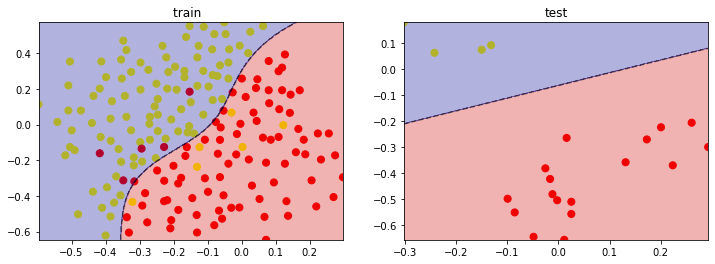

********
fold5 ==> 🛠train accuracy = 93.65 ,🔬test accuracy = 100.0
************


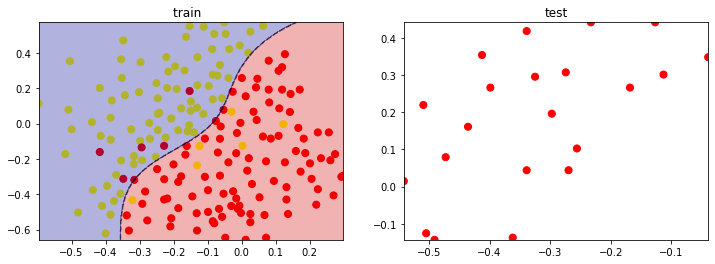

********
fold6 ==> 🛠train accuracy = 93.65 ,🔬test accuracy = 90.48
************


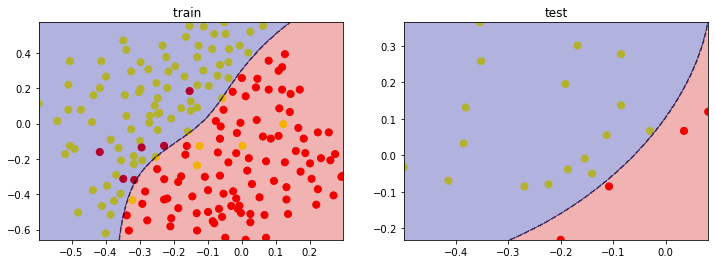

********
fold7 ==> 🛠train accuracy = 93.65 ,🔬test accuracy = 95.24
************


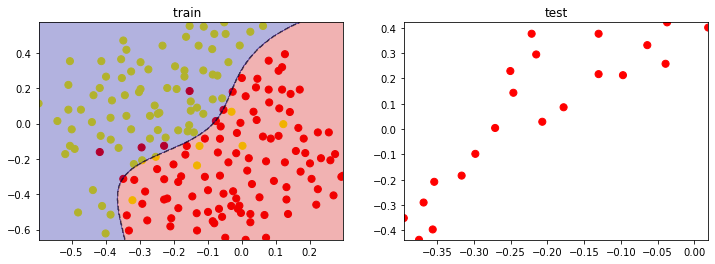

********
fold8 ==> 🛠train accuracy = 93.65 ,🔬test accuracy = 76.19
************


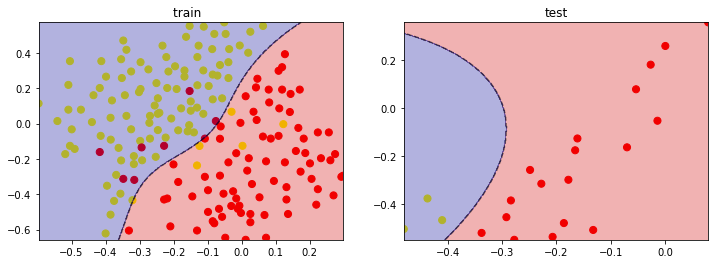

********
fold9 ==> 🛠train accuracy = 93.12 ,🔬test accuracy = 100.0
************


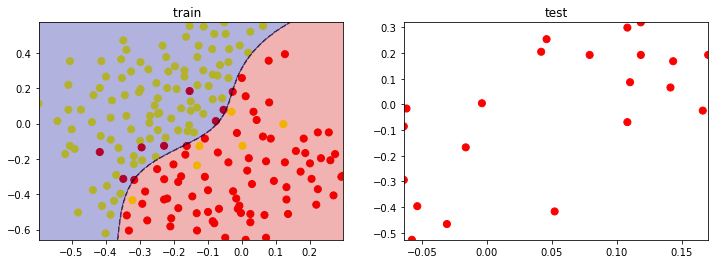

********
fold10 ==> 🛠train accuracy = 95.24 ,🔬test accuracy = 80.95
************


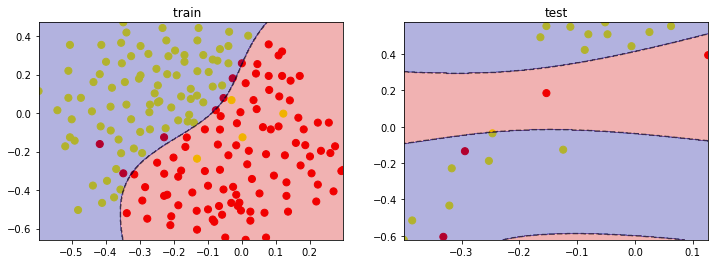

In [224]:
KfoldResult1 = []
for i in range(len(folds1)):
    testdata = folds1[i]
    traindata = folds1[0]
    
    for j in range(len(folds1)):
        if( i != j ):
            traindata = np.concatenate((traindata , folds1[j]))
    for d in range(traindata.shape[0]):
        if(d < 21):
            traindata = np.delete(traindata , d , 0)
        
    
            

    Xn =  np.delete(traindata , 2 , 1)
    Yn = traindata[:,2]
    Xntest = np.delete(testdata , 2 , 1)
    Yntest = testdata[:,2]
    Yn[Yn==-1] = 0
    Yntest[Yntest==-1] = 0
    
   
    
    sv = SVM(C=bestC1,sigma=bestSigma1)
    sv.fit(Xn,Yn)
    pred = sv.predict(Xn)
    acc = np.mean(Yn == pred)
    testpred = sv.predict(Xntest)
    acctest = np.mean(Yntest == testpred)
    objective = (acctest*100*1.5)+acc*100 
    KfoldResult1.append([acc,acctest])
    print('********')
    print('fold'+str(i+1)+' ==> 🛠train accuracy = '+str(round(acc*100,2))+' ,🔬test accuracy = '+str(round(acctest*100 ,2)) )
    print('************')
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
    test_plot(Xn , Yn , SVM( C=bestC1, sigma=bestSigma1) , axs[0] , 'train  ')
    test_plot(Xntest , Yntest , SVM( C=bestC1, sigma=bestSigma1) , axs[1] , 'test')
    plt.show()

plot best and worst  of sigma and C OF Dataset 1 
step0
step1
step2
step0
step1


/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_982/3309194586.py:14: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


step2


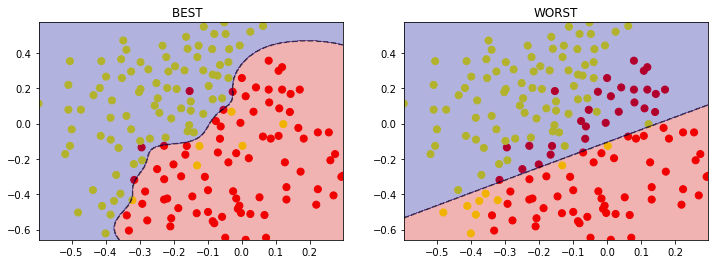

In [171]:
print('plot best and worst  of sigma and C OF Dataset 1 ')
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X , Y , SVM( C=bestC, sigma=bestSigma) , axs[0] , 'BEST  ')
test_plot(X , Y , SVM( C=worstC, sigma=WorstSigma) , axs[1] , 'WORST')

plot best and worst  of sigma and C OF Dataset 2 
step0
step1
step2
step0
step1


/var/folders/gv/29bx0dbj5fvf2ql1sq4xwxsh0000gn/T/ipykernel_982/3309194586.py:14: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


step2


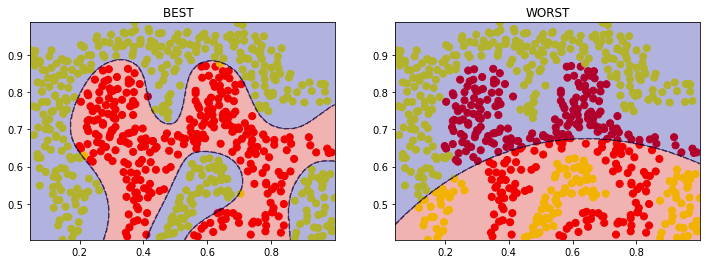

In [177]:
print('plot best and worst  of sigma and C OF Dataset 2 ')
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X2 , Y2 , SVM( C=bestC1, sigma=30) , axs[0] , 'BEST  ')
test_plot(X2 , Y2 , SVM( C=worstC1, sigma=worstSigma1) , axs[1] , 'WORST')